# Time series example


This note book uses a dataset on air pollution to look at a time series on pollution
The source of the dataset is https://archive.ics.uci.edu/ml/datasets/Air+quality

The Neural Network code came from https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras

* This is an example of using recurrent neural network to fit a time series (https://en.wikipedia.org/wiki/Recurrent_neural_network)
* The data set is a readings from a number of pollution senors in a field an Italian city. Data were recorded from March 2004 to February 2005 

## Exercises

*  Look at the data set, check that the treatment of the commnas in the number is correct.
*  Can you select another column to run through the analysis?
*  See if you can add aditional layers to the Neural Network to improve the accuracy.
*  A key parameter to play with is window_size 

I don't believe that the Neural Network is predicting 40% of the time series.
See the blog post by Google https://deepmind.com/blog/machine-learning-can-boost-value-wind-energy/



In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Read the data from the csv file using PANDAS
Note that the numbers use an Italian convention for the use of commas in numbers 
http://www.woodwarditalian.com/lesson/commas-and-periods-in-italian-numbers/

In [2]:

# The file below should be downloaded with this notebook from Github
fname = "AirQualityUCI.csv"
print("Reading from " , fname) 

df = pd.read_csv(fname, sep=";" ,  thousands=',')

print(df.tail() )

print("Summary of Nan")
print(df.isna().sum())

print("Time ")
print(df["C6H6(GT)"][0])

Reading from  AirQualityUCI.csv
            Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
9352  04/04/2005  10.00.00      31         1314      -200       135   
9353  04/04/2005  11.00.00      24         1163      -200       114   
9354  04/04/2005  12.00.00      24         1142      -200       124   
9355  04/04/2005  13.00.00      21         1003      -200        95   
9356  04/04/2005  14.00.00      22         1071      -200       119   

      PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
9352           1101      472           539      190          1374   
9353           1027      353           604      179          1264   
9354           1063      293           603      175          1241   
9355            961      235           702      156          1041   
9356           1047      265           654      168          1129   

      PT08.S5(O3)    T   RH    AH  Unnamed: 15  Unnamed: 16  
9352         1729  219  293  7568          NaN          NaN  
93

Clean the data up a bit. There were a couple of stange negative values, which the script will remove

In [3]:
ll = len( df["C6H6(GT)"]  ) 

print("Number of data items " , ll)
xx = range(0,ll)

yy = [] 
for y in  df["C6H6(GT)"] :
   if y > 0 :
      yy.append(y)



Number of data items  9357


# Do simple visualization of the data

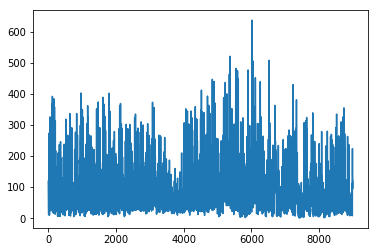

In [4]:
dim = len(yy)
xx = range(0,dim)

plt.plot(xx,yy)
plt.show()

# Neural network analysis

In [5]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle


Using TensorFlow backend.


Refiormat the data and scale the data to the range 0 to 1

In [6]:
data_raw = np.zeros((1, dim))
for ii in xx :
  data_raw[0, ii] = yy[ii] 

# Apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
##dataset = scaler.fit_transform(data_raw)
dataset = scaler.fit_transform(data_raw.reshape(-1, 1))

In [7]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))



Number of entries (training set, test set): (5394, 3597)


In [8]:
# A function to reformat the data
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))



The parameter below looks how far ahead the neural network fits 


In [9]:
window_size = 50

Yet more reformatting of the data

In [10]:
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)



Original training data shape:
(5343, 50)
New training data shape:
(5343, 1, 50)


# Define the neural network

In [11]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 2, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)


# Run the neural network

In [12]:
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/2
 - 9s - loss: 0.0047
Epoch 2/2
 - 8s - loss: 0.0031


# Evaluate the neural network

In [13]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)



Training data score: 32.77 RMSE
Test data score: 35.37 RMSE


# Plot the time series and Neural Network fit

In [14]:
# Start with training predictions.                                                                                     
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict


# Add test predictions.                                                                                                
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

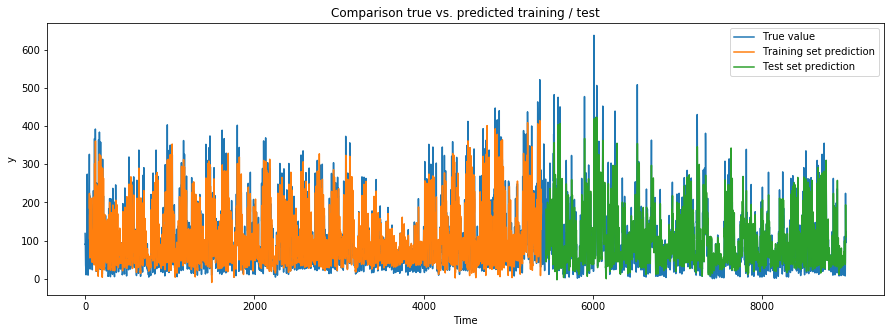

In [15]:
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Time")
plt.ylabel("y")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
